In [2]:
import numpy as np

class Layer():
    def __init__(self,model, acti_func, d_acti_func,input_dim = None, output_dim = None, first_layer=False, last_layer=False,learning_rate = 0.0075):
        self.model = model
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.learning_rate = learning_rate
        

        self.A = None
        self.Z = None
        
        self.dW = None
        self.db = None
        self.dA = None # actually gradient of output of prev layer
        self.dZ = None
        
        self.first_layer = first_layer
        self.last_layer = last_layer
        
        self.acti_func = acti_func
        self.d_acti_func = d_acti_func
        
        self.next_layer = None
        self.prev_layer = None
        
    def random_initialize(self):
        self.W = np.random.randn(self.output_dim, self.input_dim)/np.sqrt(self.input_dim)  #*np.sqrt(2/self.input_dim)
        #self.W = np.random.randn(self.output_dim, self.input_dim)*0.01
        self.b = np.zeros(shape=(self.output_dim, 1))
        
    def forward_propagate(self):
        if self.first_layer:
            prev_A = self.model.data
        else:
            prev_A = self.prev_layer.A

        self.Z = self.W.dot(prev_A) + self.b
                
        self.A = self.acti_func(self.Z)
        
    def backward_propagate(self):
        if self.first_layer:
            prev_A = self.model.data
        else:
            prev_A = self.prev_layer.A
            
        if self.last_layer:
            next_dA = self.model.calculate_cost_derivative(self.A)
        else:
            next_dA = self.next_layer.dA

        m = prev_A.shape[1]
                
        self.dZ = next_dA*self.d_acti_func(self.Z)
        self.dW = self.dZ.dot(prev_A.T)/m
        self.db = np.sum(self.dZ, axis=1, keepdims=True)/m
        self.dA = self.W.T.dot(self.dZ)
        
    def optimize(self):
        self.W -= self.learning_rate*self.dW
        self.b -= self.learning_rate*self.db


#description = [{"layer_size" : 10, "activation" : "sigmoid"}, 
#               {"layer_size" : 20, "activation" : "sigmoid"}, 
#               {"layer_size" : 20, "activation" : "sigmoid"},
#               {"layer_size" : 1, "activation" : "sigmoid"}]

class NN():
    def __init__(self, description, input_size, cost_function, train_data = None, train_labels = None,learning_rate = 0.0075):
        self.learning_rate = learning_rate
        self.layers = self.create_architecture(description, input_size)
        self.data = train_data
        self.labels = train_labels
        
        # cost_function(y, y_hat)
        self.cost_function, self.d_cost_function = cost_functions[cost_function]
        
    def calculate_cost(self, y_hat):
        return self.cost_function(self.labels, y_hat)
    
    def calculate_cost_derivative(self, y_hat):
        return self.d_cost_function(self.labels, y_hat)
        
    def calculate_accuracy(self,test_data, test_labels):
        # Works for binary input right now
        self.data = test_data
        self.labels = test_labels
        
        self.forward_pass()
        
        y_hat = self.layers[-1].A
        
        pred = np.where(y_hat > 0.5, 1, 0)
            
        return (pred == self.labels).mean()
                
        
    def create_architecture(self, description, input_size):
        layers = []
        
        for index, descr in enumerate(description):
            print(index)
            input_dim = input_size if index == 0 else layers[-1].output_dim
            output_dim = descr["layer_size"]
            activ, d_activ = activation_functions[descr["activation"]]
            
            layer = Layer(self, activ, d_activ,input_dim, output_dim,
                         first_layer=(index ==  0 ), last_layer = (index == len(description) - 1),learning_rate = self.learning_rate)
            
            # set pointers
            if index != 0:
                layers[-1].next_layer = layer
                layer.prev_layer = layers[-1]
                
            layers.append(layer)
    
        # "layers" is populated now. Initialize weights
        for layer in layers:
            layer.random_initialize()
            
        return layers
    
    def add_data(self, train_data, train_labels):
        self.data = train_data
        self.labels = train_labels
        
    def forward_pass(self):
        for layer in self.layers:            
            layer.forward_propagate()
            
    def backward_pass(self):
        for layer in reversed(self.layers):
            layer.backward_propagate()
            
    def optimize(self):
        for layer in self.layers:
            layer.optimize()
    
    def train(self, epocs):
        history = []
        
        for i in range(epocs):
            self.forward_pass()
        
            cost = self.calculate_cost(self.layers[-1].A)
            history.append(cost)
            
            if i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))        
            self.backward_pass()
                        
            self.optimize()

        
        # Training done. Return history
        return history

In [3]:
import numpy as np

def cross_entropy_sigmoid(y, y_hat):
    m = y.shape[1]
    #cost = np.sum(y*np.log(y_hat) + (1-y)*np.log(1 - y_hat)) / (-1*m)
    cost = (1./m) * (-np.dot(y,np.log(y_hat).T) - np.dot(1-y, np.log(1-y_hat).T))
    
    # So that we have a real number at the end instead of a singleton; e.g. [[3]] => 3
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

def cross_entropy_softmax(y, y_hat):
    # y is a vector of dimension [1 x num_of_inputs]
    # IT IS NOT ONE HOT VECTOR !!!
        
    num_inputs = y_hat.shape[1]
    
    # get the probabilities indexed by classes, y_hat
    probs = y_hat[y.squeeze(), range(num_inputs)]

    
    log_probs = np.log(probs)
    
    cost = np.sum(log_probs)/(-1*num_inputs)
    
    # So that we have a real number at the end instead of a singleton; e.g. [[3]] => 3
    cost = cost.squeeze()
    assert(cost.shape == ())
    
    return cost

def cross_entropy_sigmoid_derivative(y, y_hat):
    m = y.shape[1]
    return (-(np.divide(y, y_hat) - np.divide(1 - y, 1 - y_hat)))

def cross_entropy_softmax_derivative(y, y_hat):
    # y is a vector of dimension [1 x num_of_inputs]
    # IT IS NOT ONE HOT VECTOR !!!

    num_inputs = y_hat.shape[1]
    
    d = np.zeros(y_hat.shape)
    
    d[y, range(num_inputs)] = 1/y_hat[y, range(num_inputs)]
    
    return d/num_inputs

def mean_squared(y, y_hat):
    return  np.sum((y - y_hat)**2 ).squeeze() / (y_hat.shape[1]*2)

def d_mean_squared(y, y_hat):
    return (y_hat - y)


cost_functions = {"cross_entropy_sigmoid" : (cross_entropy_sigmoid, cross_entropy_sigmoid_derivative),
                 "cross_entropy_softmax" : (cross_entropy_softmax, cross_entropy_softmax_derivative),
                  "mean_squared" : (mean_squared, d_mean_squared)
                 }

In [4]:
import numpy as np

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    
    return s

def d_sigmoid(x):
    s = 1/(1+np.exp(-x))
    
    return s*(1-s)

def relu(x):
    r = np.maximum(0,x)
    
    assert(x.shape == r.shape)
    
    return r

def d_relu(x):
    r = np.where(x > 0, 1, 0)
    
    assert(x.shape == r.shape)
    
    return r

def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    d = tanh(x)
    return 1 - d*d

def linear(x):
    return x

def d_linear(x):
    return np.ones(shape=x.shape)

activation_functions = {"sigmoid" : (sigmoid, d_sigmoid) , "relu" : (relu, d_relu), "tanh" : (tanh, d_tanh), "linear" : (linear, d_linear)}

In [56]:
import numpy as np
np.set_printoptions(suppress=True)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_digits, load_iris

def split_dataset(X,y):
    # size of X : [num_input x num_dimension]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
    train_X = train_X.T
    test_X = test_X.T
    
    
    return train_X, train_y, test_X, test_y

def normalize_data(train_X, test_X):
    means = np.mean(train_X, axis = 1, keepdims=True)
    std_dev = np.std(train_X, axis = 1, keepdims=True)

    train_X = (train_X - means)/std_dev
    test_X = (test_X - means)/std_dev
    
    return train_X, test_X, means, std_dev


# From https://machinelearningmastery.com/generate-test-datasets-python-scikit-learn/
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_regression,make_s_curve, make_friedman1
from matplotlib import pyplot
from pandas import DataFrame
# # generate 2d classification dataset
# X_1,y_1 = make_moons(n_samples=1000)
# y_1 = np.array(y_1).reshape((len(y_1),1))
# #X, y = make_blobs(n_samples=1000, centers=2, n_features=2)

# # scatter plot, dots colored by class value
# df = DataFrame(dict(x=X_1[:,0], y=X_1[:,1], label=y_1.squeeze()))
# colors = {0:'red', 1:'blue', 2:'green'}
# fig, ax = pyplot.subplots()
# grouped = df.groupby('label')
# print(X_1.shape, y_1.shape)
# for key, group in grouped:
#     group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
# pyplot.show()

res = load_breast_cancer(return_X_y=True)

X_2,y_2 = res
y_2 = y_2.reshape((len(y_2), 1))

In [57]:
train_X, train_y, test_X, test_y = split_dataset(X_2,y_2)

train_y = train_y.reshape((1, len(train_y)))
test_y = test_y.reshape((1, len(test_y)))

# normalize_data
train_X, test_X, means, std_dev = normalize_data(train_X, test_X)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((30, 455), (1, 455), (30, 114), (1, 114))

0
1
2
3
Cost after iteration 0: 0.722385
Cost after iteration 100: 0.697372
Cost after iteration 200: 0.677074
Cost after iteration 300: 0.659544
Cost after iteration 400: 0.643883
Cost after iteration 500: 0.629288
Cost after iteration 600: 0.615450
Cost after iteration 700: 0.602025
Cost after iteration 800: 0.589006
Cost after iteration 900: 0.576344
Cost after iteration 1000: 0.563781
Cost after iteration 1100: 0.551335
Cost after iteration 1200: 0.538830
Cost after iteration 1300: 0.526214
Cost after iteration 1400: 0.513492
Cost after iteration 1500: 0.500589
Cost after iteration 1600: 0.487802
Cost after iteration 1700: 0.474926
Cost after iteration 1800: 0.462064
Cost after iteration 1900: 0.449341
Cost after iteration 2000: 0.436702
Cost after iteration 2100: 0.424042
Cost after iteration 2200: 0.411385
Cost after iteration 2300: 0.398745
Cost after iteration 2400: 0.386120
Cost after iteration 2500: 0.373476
Cost after iteration 2600: 0.360829
Cost after iteration 2700: 0.348

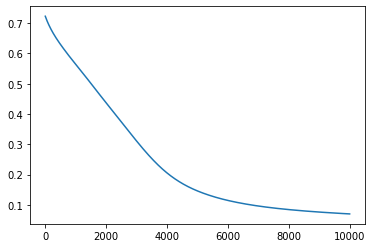

In [59]:
description = [{"layer_size" : 100, "activation" : "relu"},
               {"layer_size" : 50, "activation" : "relu"},
               {"layer_size" : 10, "activation" : "relu"},
               {"layer_size" : 1, "activation" : "sigmoid"}]

model = NN(description,30,"cross_entropy_sigmoid", train_X, train_y, learning_rate=0.001)

history = model.train(10000)

plt.plot(history)

In [52]:
acc = model.calculate_accuracy(train_X, train_y)
print("Accuracy of the model on the training set is = {}".format(acc))

acc = model.calculate_accuracy(test_X, test_y)
print("Accuracy of the model on the test set is = {}".format(acc))

Accuracy of the model on the training set is = 0.6916666666666667
Accuracy of the model on the test set is = 0.5666666666666667
